In [71]:
import pandas as pd
import pickle,os, copy
os.environ["PATH_TO_DEEP_FOLDER"] = "/rds/general/user/dl2119/home/deep_generalizability"

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
import scipy
import seaborn as sns
from sklearn.isotonic import IsotonicRegression

import re

import margin_flatness as mf
import margin_flatness.postprocessing as mf_post

import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
plt.rcParams["figure.figsize"] = (13,9)

COLORS = plt.cm.tab20(np.arange(20))

CORRECT_COLOR_IDX = 3
INCORRECT_COLOR_IDX = 1

In [74]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "CIFAR10"

exp_name = ""

exp_name = "LeNet_short" #"May19_00-32-38_cx3-7-9.cx3.hpc.ic.ac.uk"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp_name)


In [75]:
stats_df = mf_post.stats_plotting.get_end_stats(experiment_folder, step=-1)


In [9]:
stats_df.sort_values(by="Acc Test Mean", ascending=False)

KeyError: 'Acc Test Mean'

## Get cached data

In [6]:
# mf.save_load.join_cached_sub_data(experiment_folder, "point_traces", -1, "May18_23-54-38")
# mf.save_load.join_cached_sub_data(experiment_folder, "point_loss", -1, "May18_23-54-28")
# mf.save_load.join_cached_sub_data(experiment_folder, "inp_out_jacobian", -1, "May18_23-58-31")

In [93]:
len(all_point_loss)

432

In [45]:
all_point_traces, _ = mf.save_load.load_cached_data(experiment_folder, "point_traces", step=-1, time_stamp="May25_16-21-58-862654-joined")
all_point_loss, _ = mf.save_load.load_cached_data(experiment_folder, "point_loss", step=-1, time_stamp="May25_17-48-36-470248-joined")
inp_out_jacobian, _ = mf.save_load.load_cached_data(experiment_folder, "inp_out_jacobian", step=-1, time_stamp="May25_16-19-33-203813-joined")
output_margins, _ = mf.save_load.load_cached_data(experiment_folder, "output_margins", step=-1, time_stamp="May25_15-00-54-625745-joined")

post_dict = {"traces": all_point_traces, "losses": all_point_loss, "jacobian": inp_out_jacobian, "margins": output_margins}
# post_dict = {"traces": all_point_traces, "margins": output_margins, "jacobian": inp_out_jacobian,}

train_loss_acc, _ = mf.save_load.load_cached_data(experiment_folder, "model_loss_acc", step=-1, time_stamp="May25_14-28-14-776489-joined")
test_loss_acc, _ = mf.save_load.load_cached_data(experiment_folder, "model_loss_acc", step=-1, time_stamp="May25_14-28-14-733072-joined")
loss_acc_dict = {k: {"acc_train": train_loss_acc[k][1]['0'], "acc_test": test_loss_acc[k][1]['0'], "loss_train": train_loss_acc[k][0]['0'], "loss_test": test_loss_acc[k][0]['0']} for k in train_loss_acc}
loss_acc_df = pd.DataFrame(data=loss_acc_dict.values(), index=loss_acc_dict.keys())

# loss_acc_dict = {losses: }

# Get processed DF

In [46]:
def get_all_kendalls(exp_post_dict, exp_ids, configs):
    kendall_coeffs = {}
    
    for k1 in exp_post_dict.keys():
        for k2 in exp_post_dict.keys():
            # We continue since kendall is symmetric
            if (k2, k1) in kendall_coeffs or k1 == k2:
                continue
            kendall_coeffs[(k1, k2)] = {}

            for exp_id in exp_ids:
                kendall_coeffs[(k1, k2)][exp_id] = mf_post.correlation.get_kendall(exp_post_dict[k1][exp_id]['0'], exp_post_dict[k2][exp_id]['0'], remove_outliers=True).correlation
    
    hp_df = get_hp_df(configs)        
    kendall_coeffs_df = pd.DataFrame(kendall_coeffs)
    return pd.concat([kendall_coeffs_df, hp_df], axis=1)


def get_all_r2(exp_post_dict, exp_ids, configs):
    r2_coeffs = {}
    
    for k1 in exp_post_dict.keys():
        for k2 in exp_post_dict.keys():
            # We continue only if equal. r2 is not symmetric, so we get the max
            if k1 == k2:
                continue
            
            if (k1, k2) not in r2_coeffs:
                r2_coeffs[(k1, k2)] = {}

            for exp_id in exp_ids:
                if (k2, k1) in r2_coeffs:
                    try:
                        r2_coeffs[(k2, k1)][exp_id] = max(r2_coeffs[(k2, k1)][exp_id], mf_post.correlation.get_isotonic_r_squared(exp_post_dict[k1][exp_id]['0'], exp_post_dict[k2][exp_id]['0'], remove_outliers=True, increasing="auto"))
                    except:
                        pass
                else:
                    try:
                        r2_coeffs[(k1, k2)][exp_id] = mf_post.correlation.get_isotonic_r_squared(exp_post_dict[k1][exp_id]['0'], exp_post_dict[k2][exp_id]['0'], remove_outliers=True, increasing="auto") 
                    except:
                        r2_coeffs[(k1, k2)][exp_id] = np.nan
            
    hp_df = get_hp_df(configs)        
    r2_coeffs_df = pd.DataFrame(r2_coeffs)
    return pd.concat([r2_coeffs_df, hp_df], axis=1)


def get_hp_df(configs):
    cfs_hp = mf_post.utils.get_hp(configs)
    cfs_hp_df = configs[list(cfs_hp.keys())]
    return cfs_hp_df

cfgs = mf.save_load.load_configs(experiment_folder)
exp_ids = list(cfgs.index)
# exp_ids = ["1621270824.0509984"]
kendall_df = get_all_kendalls(post_dict, exp_ids, cfgs)
r2_df = get_all_r2(post_dict, exp_ids, cfgs)


In [47]:
def subset_df(df, p_types, config_subset):
    index_filter = [True] * len(df)
    for k, v in config_subset.items():
        index_filter = index_filter & (df[k] == v)
            
    if len(p_types) == 1:
        return df[df.columns[[p_types[0] in c for c in df.columns]]][index_filter]
    
    col_filter = []
    for c in df.columns:
        if c[0] in p_types and c[1] in p_types:
            col_filter.append(True)
        else:
            col_filter.append(False)
    return df[df.columns[col_filter]][index_filter]

In [48]:


kendall_df_new = pd.concat([kendall_df, loss_acc_df], axis=1)
r2_df_new = pd.concat([r2_df, loss_acc_df], axis=1)

# kendall_df_new[kendall_df_new["optimizer"] == "RMSProp"].sort_values("train_loss")
# kendall_df_new.sort_values("train_loss").tail(25)
r2_df_new.groupby(["criterion", "optimizer", "learning_rate"]).mean().sort_values(("margins", "jacobian"))#.head(50)#[kendall_df_new["criterion"] == "cross-entropy"].sort_values(("traces", "losses"), ascending=False).head(40) # .groupby(["learning_rate","optimizer", "criterion"]).mean() #.loc["1621270824.0509984"]

(traces, losses)  (traces, jacobian)  \
criterion     optimizer learning_rate                                         
MSE           Adam      0.000001               0.068750            0.014688   
                        0.000005               0.051762            0.018801   
                        0.000010               0.055067            0.028751   
                        0.000025               0.049135            0.047445   
                        0.000050               0.057526            0.061059   
                        0.000075               0.057281            0.064116   
              RMSProp   0.000001               0.068148            0.015437   
                        0.000005               0.058048            0.021464   
                        0.000010               0.051820            0.021858   
                        0.000025               0.057780            0.051635   
                        0.000050               0.063769            0.052506   
                        0.000075               0.058246            0.053000   
              SGD       0.005000               0.043596            0.034619   
                        0.010000               0.045227            0.052732   
                        0.025000               0.052388            0.042159   
                        0.050000               0.059707            0.054969   
                        0.075000               0.068862            0.074388   
                        1.000000               0.053949            0.138198   
cross-entropy Adam      0.000001               0.110779            0.017817   
                        0.000005               0.029541            0.112087   
                        0.000010               0.021907            0.136213   
                        0.000025               0.042555            0.147698   
                        0.000050               0.081652            0.211582   
                        0.000075               0.120064            0.269281   
              RMSProp   0.000001               0.107942            0.016549   
                        0.000005               0.040861            0.082463   
                        0.000010               0.027827            0.127591   
                        0.000025               0.039739            0.141983   
                        0.000050               0.077221            0.198997   
                        0.000075               0.100970            0.284639   
              SGD       0.005000               0.548069            0.699780   
                        0.010000               0.602200            0.761365   
                        0.025000               0.645691            0.776170   
                        0.050000               0.485751            0.699843   
                        0.075000               0.365166            0.702002   
                        1.000000               1.000000            1.000000   

                                       (traces, margins)  (losses, traces)  \
criterion     optimizer learning_rate                                        
MSE           Adam      0.000001                0.048847               NaN   
                        0.000005                0.020339               NaN   
                        0.000010                0.021289               NaN   
                        0.000025                0.018071               NaN   
                        0.000050                0.009391               NaN   
                        0.000075                0.018247               NaN   
              RMSProp   0.000001                0.054942               NaN   
                        0.000005                0.027928               NaN   
                        0.000010                0.025214               NaN   
                        0.000025                0.017751               NaN   
                        0.000050                0.013478               NaN   
                      

# Plot a histogram for kendall and isotonic R^2 value. 

In [51]:
r2_df_new

,"(traces, losses)","(traces, jacobian)","(traces, margins)","(losses, traces)","(losses, jacobian)","(losses, margins)","(jacobian, traces)","(jacobian, losses)","(jacobian, margins)","(margins, traces)",...,batch_train_size,criterion,learning_rate,optimizer,seed,weight_decay,acc_train,acc_test,loss_train,loss_test
1621787441.2034013,0.678685,0.729476,0.971338,NaN,0.891396,0.977430,NaN,NaN,0.993934,NaN,...,256,cross-entropy,0.01,SGD,0,0.0001,0.9522,0.5808,0.130931,2.950856
1621786700.9018226,0.044733,0.217437,0.043659,NaN,0.437734,0.738720,NaN,NaN,0.418955,NaN,...,256,MSE,1,SGD,10,0,0.9216,0.5638,0.015690,0.068652
1621790269.6430342,0.082725,0.028982,0.036462,NaN,0.019699,0.794832,NaN,NaN,0.042675,NaN,...,128,MSE,0.025,SGD,10,0.0001,0.7000,0.5888,0.044973,0.056266
1621787496.530556,0.036044,0.145147,0.072186,NaN,0.074712,0.400288,NaN,NaN,0.217906,NaN,...,256,cross-entropy,0.000025,Adam,0,0.0001,0.4092,0.4036,1.726392,1.753100
1621786647.420346,0.046796,0.093137,0.042303,NaN,0.201037,0.440233,NaN,NaN,0.187814,NaN,...,256,cross-entropy,0.000025,Adam,5,0,0.4500,0.4570,1.584049,1.605596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621786706.9549413,0.060177,0.054584,0.048743,NaN,0.053374,0.783191,NaN,NaN,0.039464,NaN,...,128,MSE,0.05,SGD,10,0,0.7984,0.6034,0.030660,0.057727
1621787550.8746219,0.024064,0.138086,0.047980,NaN,0.114278,0.675255,NaN,NaN,0.067792,NaN,...,256,cross-entropy,0.000005,Adam,0,0.0001,0.3100,0.3096,1.997544,1.996431
1621787382.3898637,0.549985,0.784211,0.908260,NaN,0.696798,0.906974,NaN,NaN,0.992961,NaN,...,256,cross-entropy,0.075,SGD,0,0.0001,0.8656,0.5178,0.437320,2.592184
1621787594.1609957,0.138199,0.014171,0.072132,NaN,0.122407,0.780054,NaN,NaN,0.018148,NaN,...,256,cross-entropy,0.000001,Adam,0,0.0001,0.2070,0.2108,2.255276,2.252788


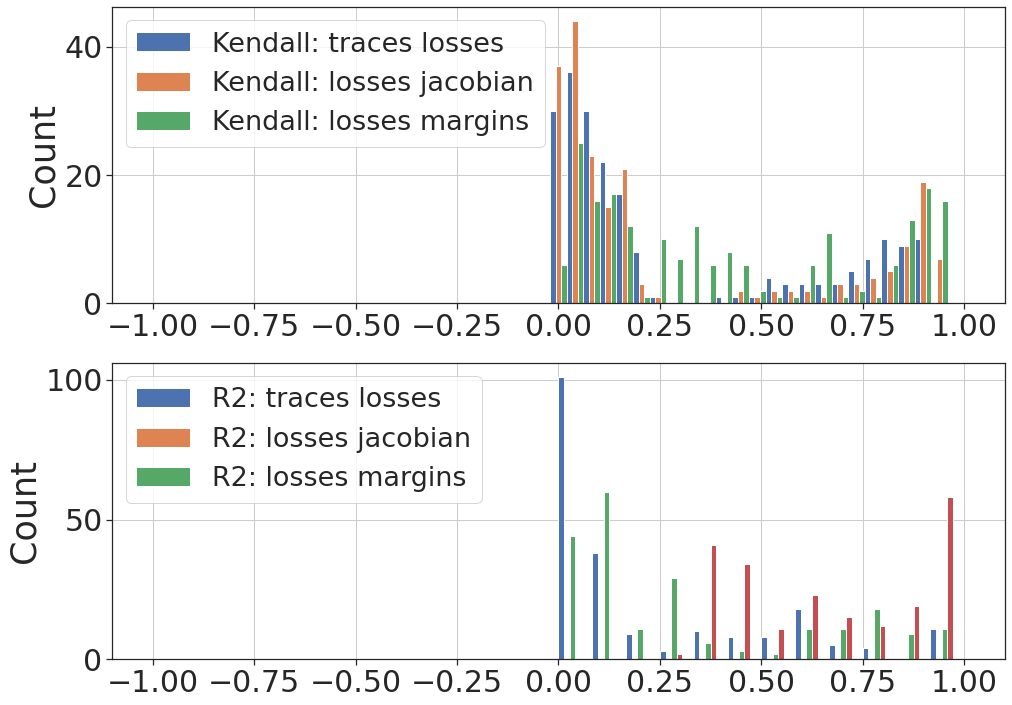

In [111]:
import seaborn as sns

config_subset = {"criterion": "cross-entropy"} #, "optimizer": "SGD"}
p_types = ["losses"]

kendall_dict_to_use = subset_df(kendall_df, p_types, config_subset)
r2_dict_to_use = subset_df(r2_df, p_types, config_subset)
    
    
kendall_values = list(np.abs(kendall_dict_to_use.values.T))
r2_values = list(r2_dict_to_use.values.T)
labels = list(kendall_dict_to_use.columns)
    
sns.set(style="ticks")
f, (ax_kendall_hist, ax_r2_hist) = plt.subplots(2, figsize=(16,12))

ax_kendall_hist.hist(kendall_values, rwidth=10, bins=np.linspace(-1, 1, 50), alpha=1, label=["Kendall: {} {}".format(l[0], l[1]) for l in labels])
ax_kendall_hist.tick_params(axis='both', labelbottom=True, labelsize=30)
ax_kendall_hist.set_ylabel(ylabel="Count", fontsize=35)
ax_kendall_hist.grid(b=True, which='major')

ax_r2_hist.hist(r2_values, rwidth=10, bins=np.linspace(-1, 1, 50), alpha=1, label=["R2: {} {}".format(l[0], l[1]) for l in labels]) # TODO: Messed up due to Nan values. 
ax_r2_hist.tick_params(axis='both', labelbottom=True, labelsize=30)
ax_r2_hist.set_ylabel(ylabel="Count", fontsize=35)
ax_r2_hist.grid(b=True, which='major')

# ax_r2_hist.set_xlim(-0.2, 0.2)
# ax_kendall_hist.set_xlim(-0.2, 0.2)

ax_kendall_hist.legend(loc="upper left", fontsize=27) #, bbox_to_anchor=(0.45, 0.95))
ax_r2_hist.legend(loc="upper left", fontsize=27) #, bbox_to_anchor=(0.3875, 0.95))


# f.savefig("../figs/kendall_r2_{}_{}".format(criterion_type, p_types), dpi=300, bbox_inches = "tight",)

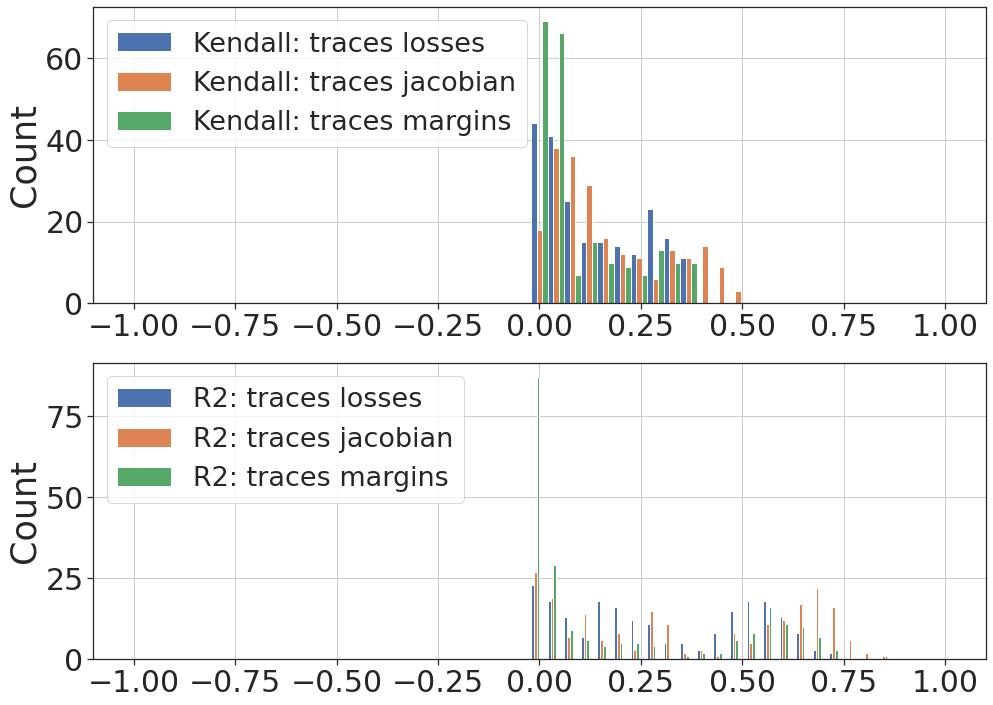

In [65]:
import seaborn as sns

criterion_type = "MSE"
p_types = ["traces"]

kendall_dict_to_use = subset_df(kendall_df, p_types, criterion_type)
r2_dict_to_use = subset_df(r2_df, p_types, criterion_type)
    
    
kendall_values = list(np.abs(kendall_dict_to_use.values.T))
r2_values = list(r2_dict_to_use.values.T)
labels = list(kendall_dict_to_use.columns)
    
sns.set(style="ticks")
f, (ax_kendall_hist, ax_r2_hist) = plt.subplots(2, figsize=(16,12))

ax_kendall_hist.hist(kendall_values, rwidth=10, bins=np.linspace(-1, 1, 50), alpha=1, label=["Kendall: {} {}".format(l[0], l[1]) for l in labels])
ax_kendall_hist.tick_params(axis='both', labelbottom=True, labelsize=30)
ax_kendall_hist.set_ylabel(ylabel="Count", fontsize=35)
ax_kendall_hist.grid(b=True, which='major')

ax_r2_hist.hist(r2_values, rwidth=10, bins=np.linspace(-1, 1, 50), alpha=1, label=["R2: {} {}".format(l[0], l[1]) for l in labels])
ax_r2_hist.tick_params(axis='both', labelbottom=True, labelsize=30)
ax_r2_hist.set_ylabel(ylabel="Count", fontsize=35)
ax_r2_hist.grid(b=True, which='major')

# ax_r2_hist.set_xlim(-0.2, 0.2)
# ax_kendall_hist.set_xlim(-0.2, 0.2)

ax_kendall_hist.legend(loc="upper left", fontsize=27) #, bbox_to_anchor=(0.45, 0.95))
ax_r2_hist.legend(loc="upper left", fontsize=27) #, bbox_to_anchor=(0.3875, 0.95))


# f.savefig("../figs/kendall_r2_{}_{}".format(criterion_type, p_types), dpi=300, bbox_inches = "tight",)

# Scatter Plot non-aggregated


In [ ]:
r2_df[r2_df["criterion"] == "MSE"].sort_values(("traces", "jacobian"), ascending=False)

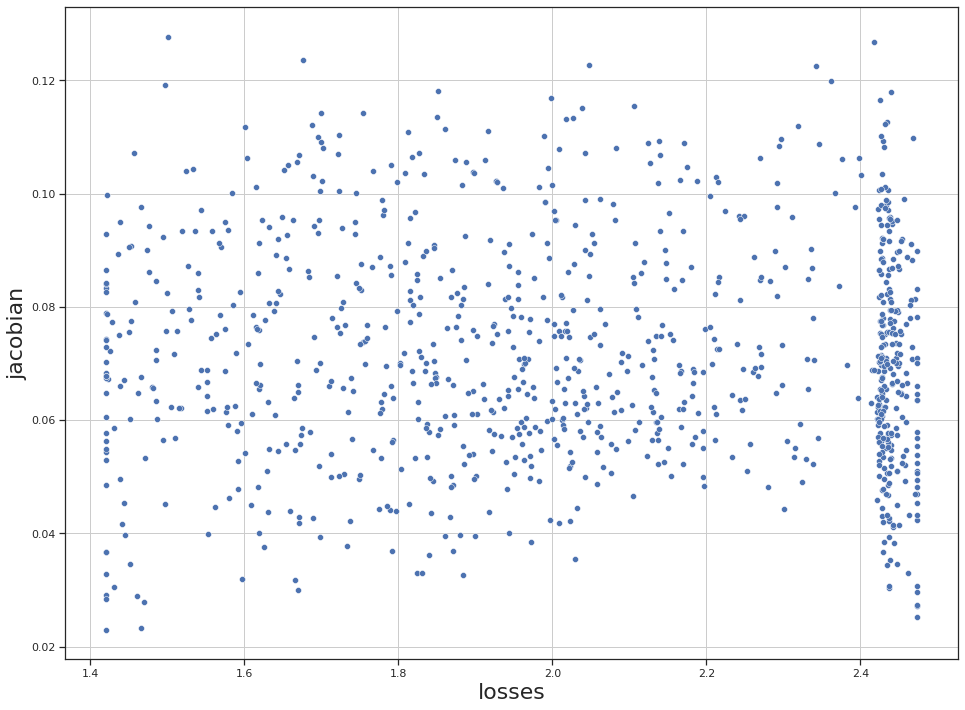

In [98]:
exp_dict = post_dict

x_type = "losses"
y_type = "jacobian"
exp_id = "1621792489.7292588"
with_isotonic = False

# print(np.mean(exp_dict["losses"][exp_id]['0']))
    
x_data = exp_dict[x_type][exp_id]['0']
y_data = exp_dict[y_type][exp_id]['0'] # exp_dict[y_type][exp_id]['0']
    
sns.set(style="ticks")

f, ax1 = plt.subplots(1, figsize=(16,12))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))
if with_isotonic:
    iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
    y_predicted = iso_reg.predict(x_data)
    sns.scatterplot(x=x_data, y=y_predicted, ax=ax1)
    
ax1.set_ylabel(ylabel=y_type, fontsize=22)
ax1.set_xlabel(xlabel=x_type, fontsize=22)
# ax1.set_ylim(-250, 3500)
ax1.grid(b=True, which='major')
# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)


# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")




# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

# Scatter Plot : Aggregated

In [192]:
def get_aggregation(exp_post_dict, exp_ids):
    res_dict = {}
    for k in exp_post_dict:
        res_dict[k] = {"mean": {}, "max": {}, "min": {}}
        for exp_id in exp_ids:
            res_dict[k]["mean"][exp_id] = np.mean(exp_post_dict[k][exp_id]['0'])
            res_dict[k]["max"][exp_id] = np.max(exp_post_dict[k][exp_id]['0'])
            res_dict[k]["min"][exp_id] = np.min(exp_post_dict[k][exp_id]['0'])
    return res_dict



def get_post_data_vals(data_type, data_subtype, post_dict, acc_dict, exp_id):
    exp_ids = list(acc_dict.keys())
    assert data_type in post_dict or data_type == "acc"    
    if "acc" != data_type:
        return post_dict[data_type][data_subtype][exp_id]
    else:
        if x_subtype == "test":
            return acc_dict[exp_id]['0'][1]
        else:
            return acc_dict[exp_id]['0'][0]


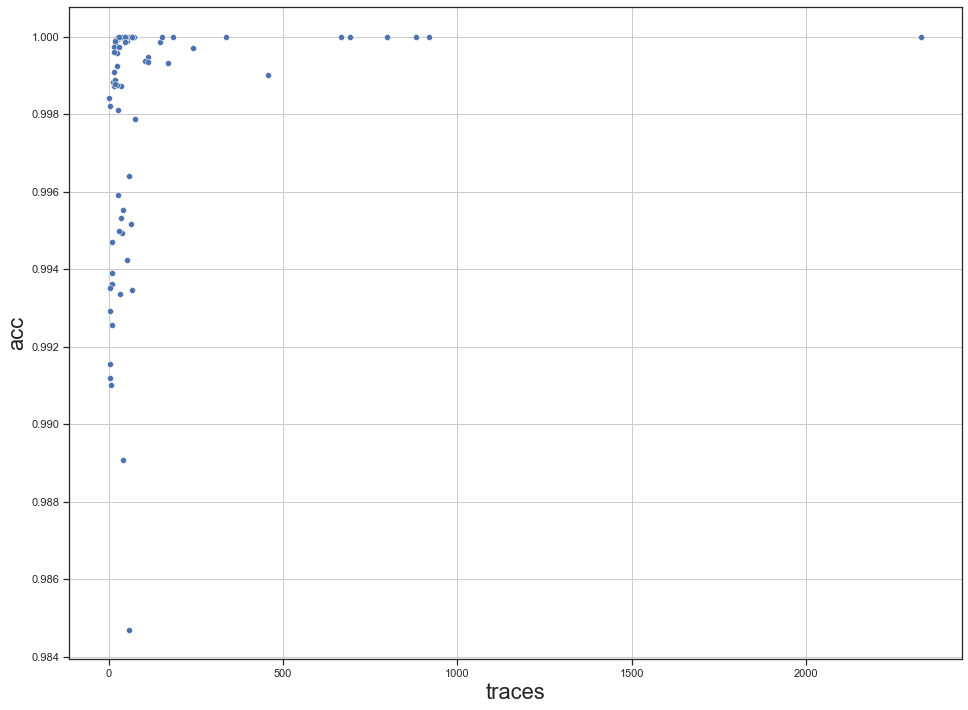

In [198]:
exp_dict = ce_dict
exp_ids = ce_stats_df.index
agg_dict = get_aggregation(exp_dict,  exp_ids)
acc_dict = ce_acc

x_type = "traces"
x_subtype = "mean"
y_type = "acc"
y_subtype = "test"

with_isotonic = True


x_data, y_data = [], []

for exp_id in exp_ids:
    x_data.append(get_post_data_vals(x_type, x_subtype, agg_dict, acc_dict, exp_id))
    y_data.append(get_post_data_vals(y_type, y_subtype, agg_dict, acc_dict, exp_id))


sns.set(style="ticks")

f, ax1 = plt.subplots(1, figsize=(16,12))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))
# if with_isotonic:
#     iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
#     y_predicted = iso_reg.predict(x_data)
#     sns.scatterplot(x=x_data, y=y_predicted, ax=ax1)
    
ax1.set_ylabel(ylabel=y_type, fontsize=22)
ax1.set_xlabel(xlabel=x_type, fontsize=22)
# ax1.set_ylim(-250, 3500)
ax1.grid(b=True, which='major')
# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

# Plot every point on one plot

In [11]:
def get_all_points(exp_post_dict, exp_ids, x_type, y_type, use_isotonic=False, keep_kendall_threshold=0.3): 
    x_res_arr, y_res_arr = [], []
    for exp_id in exp_ids:
        x_data = exp_post_dict[x_type][exp_id]['0']
        y_data = exp_post_dict[y_type][exp_id]['0']
        if use_isotonic:
            x_data, y_data = isotonic_outlier_removal(x_data, y_data, 0.02)
            iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
            y_predicted = iso_reg.predict(x_data)
#             y_predicted += (x_data - np.min(x_data)) * 0.00000002 / np.linalg.norm(x_data) * np.linalg.norm(y_data)
            x_data = y_predicted
        if abs(mf_post.correlation.get_kendall(x_data, y_data).correlation) >= keep_kendall_threshold:
            x_res_arr.append(x_data)
            y_res_arr.append(y_data)
    return np.array(x_res_arr).flatten(), np.array(y_res_arr).flatten()


LinregressResult(slope=0.9999999314771316, intercept=-9.514235898677725e-06, rvalue=0.6961980785591422, pvalue=0.0, stderr=0.0036597432240510043)

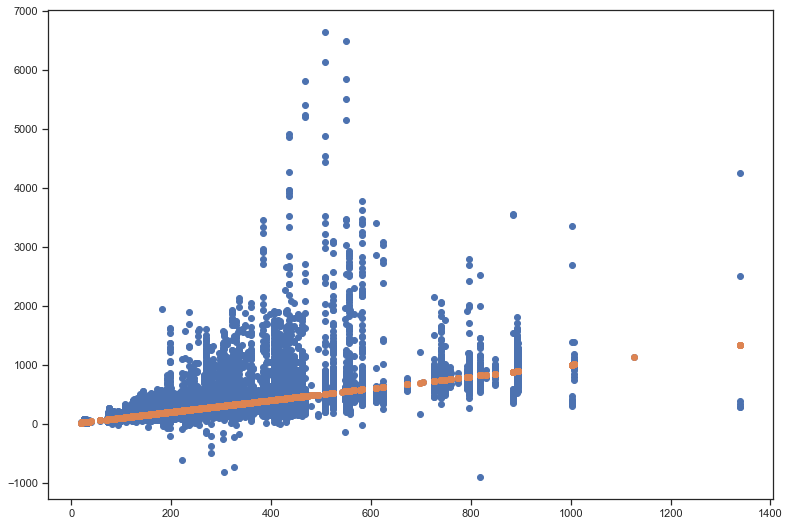

In [209]:
# plt.scatter(x_data, y_data)

# iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
# y_predicted = iso_reg.predict(x_data)
# plt.scatter(x_data, y_predicted)

# mf_post.correlation.linregress_outliers(x_data, y_data)

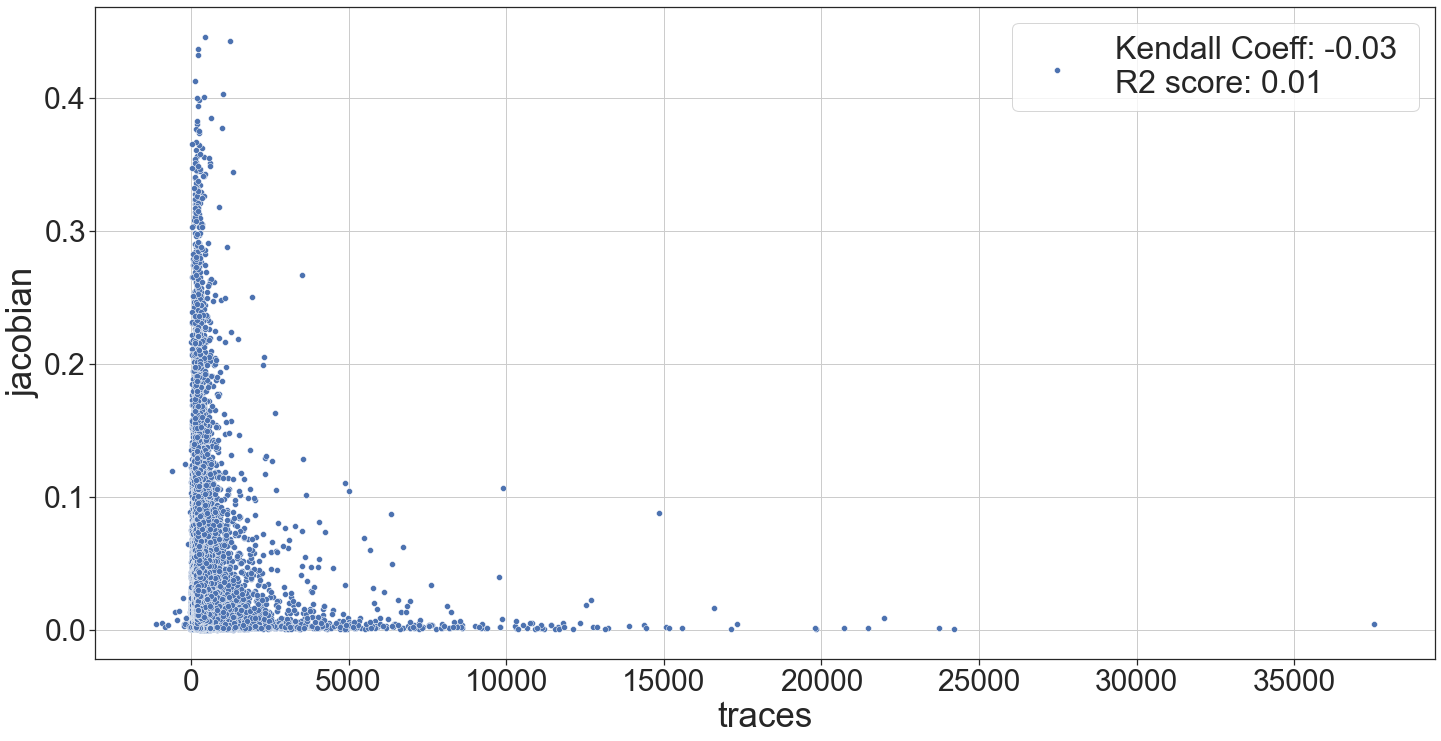

In [52]:
loss_type = "MSE"
x_type = "traces"
y_type = "jacobian"
do_isotonic = False

if loss_type == "CE":
    exp_name = ce_exp
    exp_ids = ce_stats_df.index
    x_data, y_data = get_all_points(ce_dict, exp_ids, x_type, y_type, use_isotonic=do_isotonic, keep_kendall_threshold=0)
else:
    exp_name = mse_exp
    exp_ids = mse_stats_df.index
    x_data, y_data = get_all_points(mse_dict, exp_ids, x_type, y_type, use_isotonic=do_isotonic, keep_kendall_threshold=-1)
    
c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(24,12))


sns.scatterplot(x=x_data, y=y_data, ax=ax1, label="Kendall Coeff: {:.2f} \nR2 score: {:.2f}".format(mf_post.correlation.get_kendall(y_data, x_data).correlation, mf_post.correlation.get_isotonic_r_squared(y_data, x_data)))

ax1.tick_params(axis='both', labelbottom=True, labelsize=30)

ax1.set_ylabel(ylabel=y_type, fontsize=35)
if do_isotonic:
    ax1.set_xlabel(xlabel="g_theta({})".format(x_type), fontsize=35)
else:
    ax1.set_xlabel(xlabel="{}".format(x_type), fontsize=35)
ax1.legend(loc="best", fontsize=32) #, bbox_to_anchor=(0.3875, 0.95))
ax1.grid(b=True, which='major')



# ax1.text(x=0.99, y=0.9, transform=ax1.transAxes, s="Kendall Coeff: {:.2f} \n R2 score: {:.2f}".format(mf_post.correlation.get_kendall(y_data, x_data).correlation, mf_post.correlation.get_isotonic_r_squared(y_data, x_data)) ,\
#          fontsize=30, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

# iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
# y_predicted = iso_reg.predict(x_data)
# sns.scatterplot(x=x_data, y=y_predicted, ax=ax1, color="red")


if loss_type == "CE" and y_type == "traces":
    axins2 = inset_axes(ax1, width=4, height=4, loc=2)
    sns.scatterplot(x=x_data, y=y_data, ax=axins2)

    # sub region of the original image
    x1, x2, y1, y2 = -1000, 5000, -1000, 5000
    
    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)

    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")
#     axins2.tick_params(None) # TODO unset tick_params



f.savefig("../figs/all_points_{}_{}_{}_{}".format(loss_type, x_type, y_type, do_isotonic), dpi=300, bbox_inches = "tight",)


### Using with Isotonic Regression

In [109]:

from sklearn.neighbors import LocalOutlierFactor

def get_outlier_filter(x_data, y_data):
    x_data, y_data = np.array(x_data), np.array(y_data)
    #     if len(x_data) < 5:
    #         return np.array([True]*len(x_data)) # They are all outliers since we don't have enough datapoints
    combined_data = np.concatenate([x_data.reshape(len(x_data), 1), y_data.reshape(len(y_data), 1)], axis=1)

    clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
    outlier_filter = clf.fit_predict(combined_data) == 1

       
    return x_data[outlier_filter], y_data[outlier_filter]

# get_outlier_filter(np.array(x_data), np.array(y_data))



# Plot accuracy vs correlation

In [12]:
ce_all_point_traces, _ = mf.save_load.load_cached_data(ce_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
ce_all_point_output_margins, _ = mf.save_load.load_cached_data(ce_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_20-51-39")


mse_all_point_traces, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
mse_all_point_output_margins, _ = mf.save_load.load_cached_data(mse_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_18-53-57")


In [47]:

num_nets = 1

ce_kendall_coeffs_train_acc_dict = {}
ce_kendall_coeffs_test_acc_dict = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_kendall_coeffs_train_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, ce_stats_df["Acc Train Mean"][exp_id])
        ce_kendall_coeffs_test_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, ce_stats_df["Acc Test Mean"][exp_id])

mse_kendall_coeffs_train_acc_dict = {}
mse_kendall_coeffs_test_acc_dict = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        mse_kendall_coeffs_train_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, mse_stats_df["Acc Train Mean"][exp_id])
        mse_kendall_coeffs_test_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, mse_stats_df["Acc Test Mean"][exp_id])

ce_kendall_coeffs_train_acc_arr = np.array(list(ce_kendall_coeffs_train_acc_dict.values()))
mse_kendall_coeffs_train_acc_arr = np.array(list(mse_kendall_coeffs_train_acc_dict.values()))
ce_kendall_coeffs_test_acc_arr = np.array(list(ce_kendall_coeffs_test_acc_dict.values()))
mse_kendall_coeffs_test_acc_arr = np.array(list(mse_kendall_coeffs_test_acc_dict.values()))

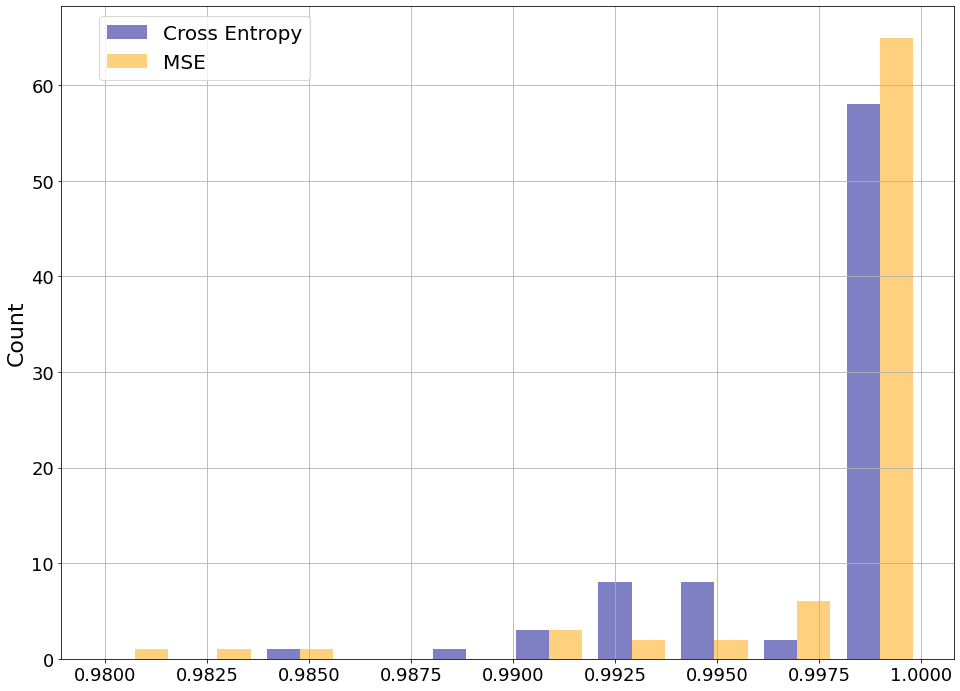

In [53]:
import seaborn as sns
f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([ce_kendall_coeffs_train_acc_arr[:, 1], mse_kendall_coeffs_train_acc_arr[:, 1]], color=['darkblue','orange'], alpha=0.5, label=["Cross Entropy", "MSE"])

ax1_hist.grid(b=True, which='major')

ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Training Accuracy", fontsize=22)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.35, 0.88))

f.savefig("../figs/train_acc", dpi=300, bbox_inches = "tight",)

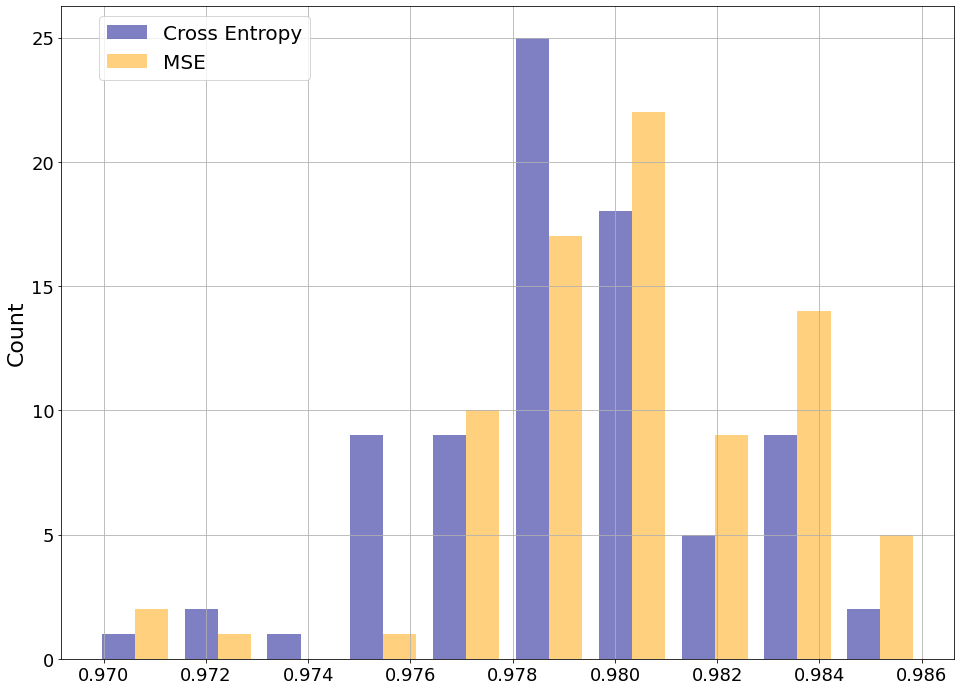

In [54]:
import seaborn as sns
f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([ce_kendall_coeffs_test_acc_arr[:, 1], mse_kendall_coeffs_test_acc_arr[:, 1]], color=['darkblue','orange'], alpha=0.5, label=["Cross Entropy", "MSE"])

ax1_hist.grid(b=True, which='major')

ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Test Accuracy", fontsize=22)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.35, 0.88))

f.savefig("../figs/test_acc", dpi=300, bbox_inches = "tight",)

# Scratch

In [146]:

num_nets = 1

ce_r2_coeffs_point_output = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_all_point_traces[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_r2_coeffs_point_output[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")


ce_r2_coeffs_point_loss = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_loss[exp_id]["{}".format(nn_idx)]
        ce_r2_coeffs_point_loss[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")

        
ce_r2_coeffs_output_margins = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_r2_coeffs_output_margins[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

In [441]:

num_nets = 1

ce_test_acc_hess = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_all_point_traces[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_test_acc_hess[exp_id] = [ce_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(ce_all_point_loss[exp_id]["{}".format(nn_idx)])]

ce_test_acc_hess_arr = np.array(list(ce_test_acc_hess.values()))

mse_test_acc_hess = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(mse_all_point_traces[exp_id]["{}".format(nn_idx)])
#         y_data = np.array(mse_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        mse_test_acc_hess[exp_id] = [mse_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(mse_all_point_loss[exp_id]["{}".format(nn_idx)])]#mse_stats_df.loc[exp_id]["Loss Train Mean"]] #np.mean(ce_all_point_traces[exp_id]["{}".format(nn_idx)])]

mse_test_acc_hess_arr = np.array(list(mse_test_acc_hess.values()))

-0.18939744269081046
0.2441076341959021


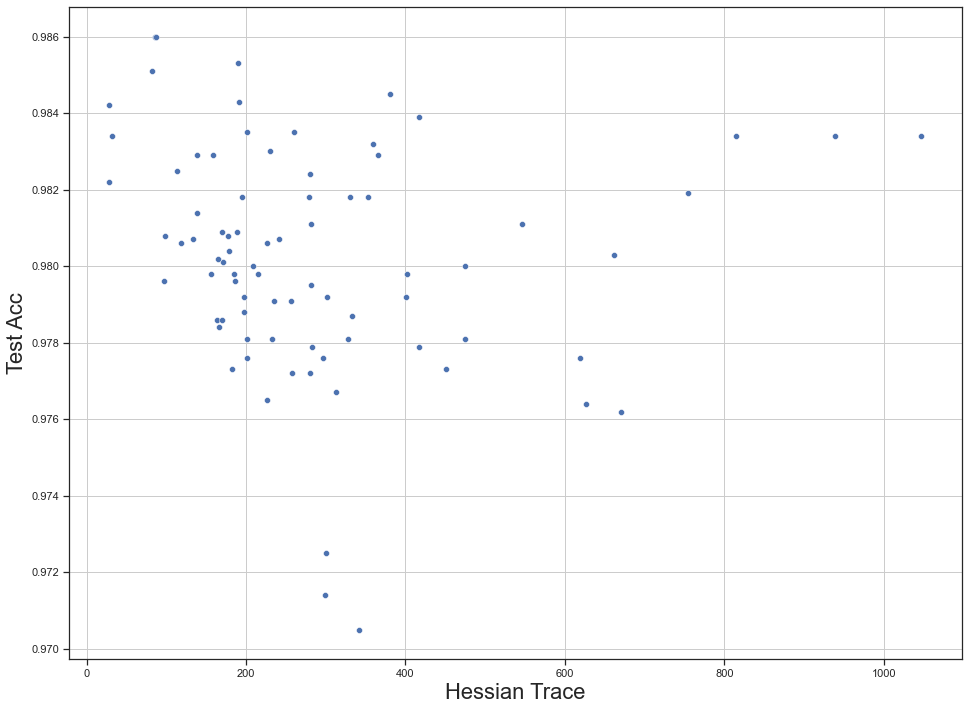

In [440]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = mse_test_acc_hess_arr[:, 1]
y_data = mse_test_acc_hess_arr[:, 0]

print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

-0.17909076695302922
0.2794703697441018


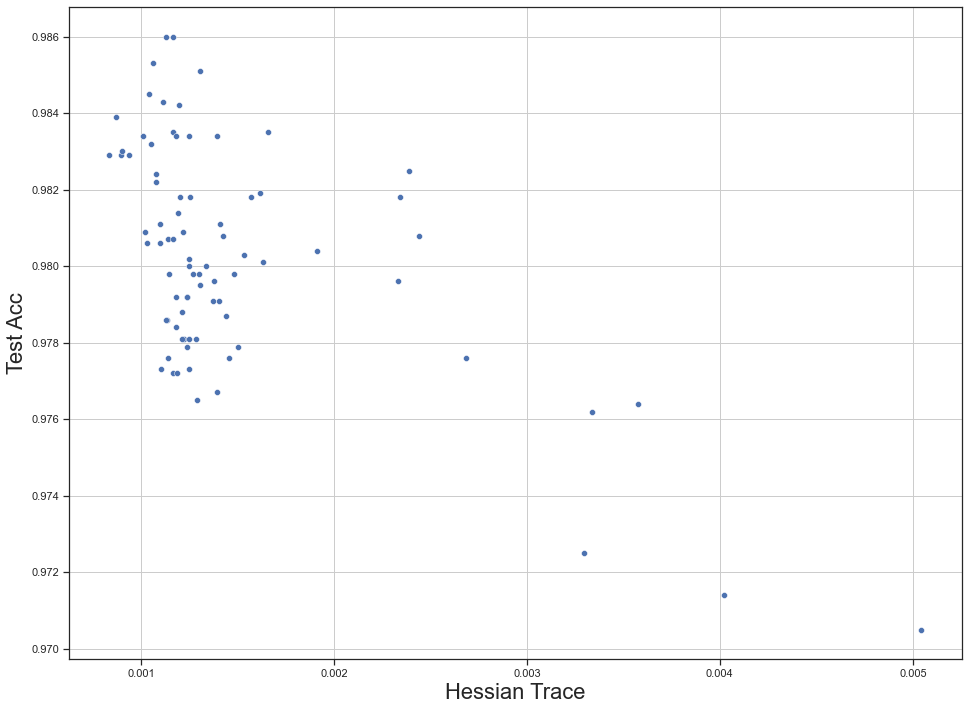

In [442]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = mse_test_acc_hess_arr[:, 1]
y_data = mse_test_acc_hess_arr[:, 0]
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [185]:


ce_sample_flatness_old, _ = mf.save_load.load_cached_data(ce_experiment_folder, "sample_average_flatness_pointwise", step=-1, time_stamp="Apr07_18-31-05")
ce_sample_flatness, _ = mf.save_load.load_cached_data(ce_experiment_folder, "sample_average_flatness_pointwise", step=-1, time_stamp="Apr08_01-23-18")



-0.2756043507513157
0.6940995507677117


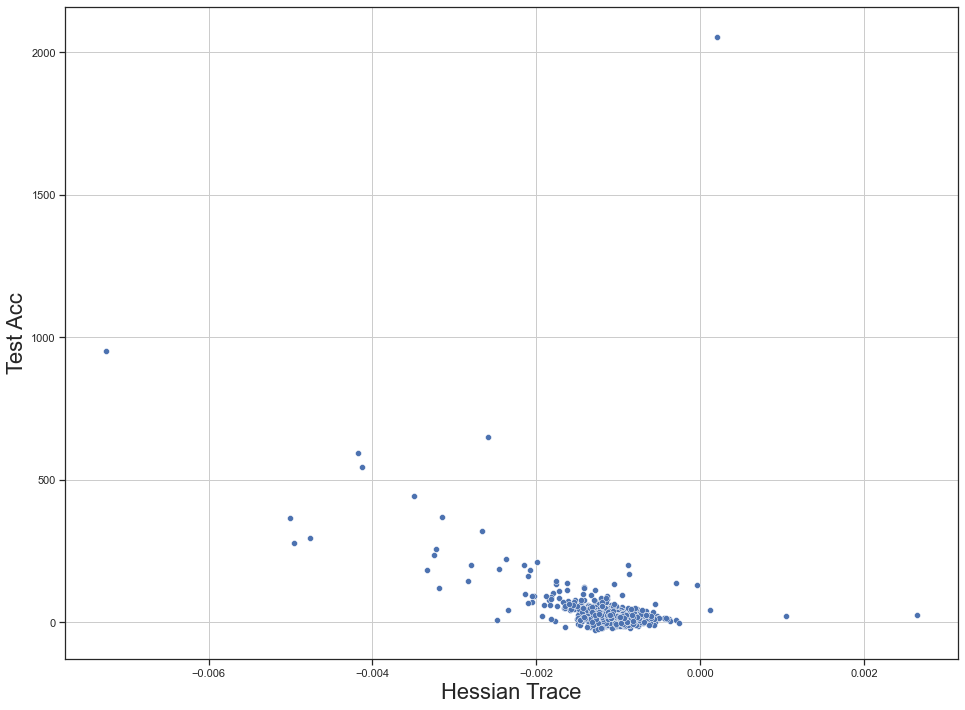

In [188]:
exp_id = list(ce_sample_flatness_old.keys())[0]
sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_sample_flatness[exp_id]['0']
y_data = ce_all_point_traces[exp_id]['0']
# y_data = ce_sample_flatness_old[exp_id]['0']
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [67]:

num_nets = 1

ce_test_acc_hess = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_sample_flatness[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_test_acc_hess[exp_id] = [ce_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(ce_sample_flatness[exp_id]["{}".format(nn_idx)])]

ce_test_acc_hess_arr = np.array(list(ce_test_acc_hess.values()))

# mse_test_acc_hess = {}
# for exp_id in mse_stats_df.index:
#     for nn_idx in range(num_nets):
#         x_data = np.array(mse_all_point_traces[exp_id]["{}".format(nn_idx)])
# #         y_data = np.array(mse_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
#         mse_test_acc_hess[exp_id] = [mse_stats_df.loc[exp_id]["Acc Test Mean"], mse_stats_df.loc[exp_id]["Loss Train Mean"]] #np.mean(ce_all_point_traces[exp_id]["{}".format(nn_idx)])]

# mse_test_acc_hess_arr = np.array(list(mse_test_acc_hess.values()))

-0.028159666101149356
0.031682753519293394


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "


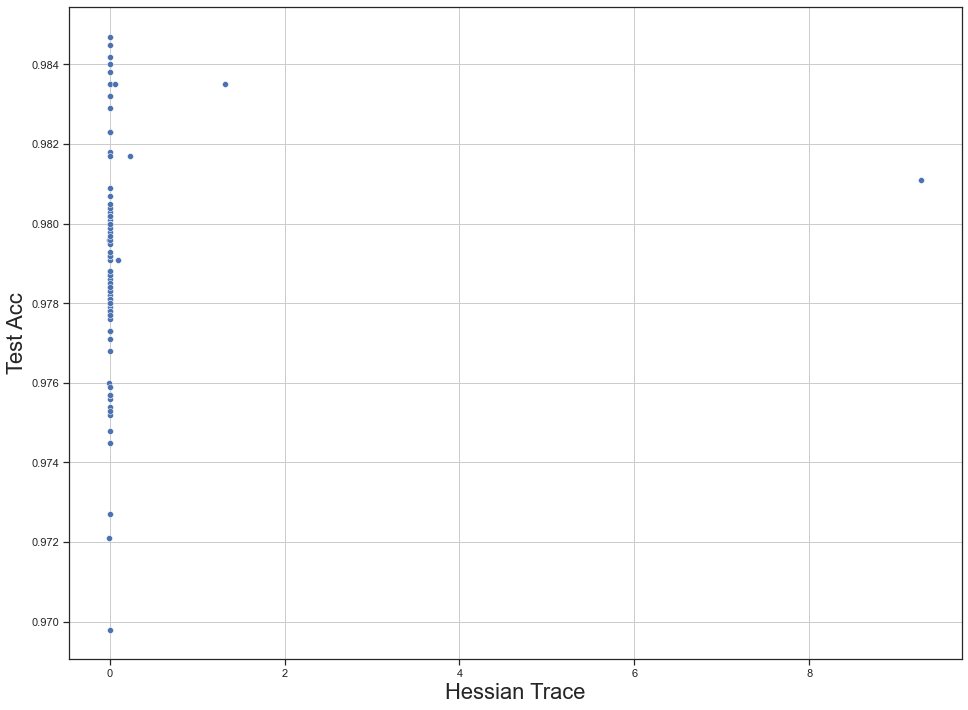

In [68]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_test_acc_hess_arr[:, 1]
y_data = ce_test_acc_hess_arr[:, 0]
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [289]:
np.argmax([0,1,2])

2

In [13]:
def isotonic_outlier_removal(x_data, y_data, percent_outlier_remove=0.05, increasing="auto"):
    num_outlier_remove = int(len(x_data)*percent_outlier_remove)
    for _ in range(num_outlier_remove):
        iso_reg = IsotonicRegression(increasing=increasing).fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        idx_max = np.argmax(np.abs(y_predicted - y_data))
        x_data = np.delete(x_data, idx_max)
        y_data = np.delete(y_data, idx_max)
    return x_data, y_data


def get_isotonic_r_squared(x_data, y_data, remove_outliers=False, increasing=False):
    if len(x_data) == 0:
        return 0, 0, 0, None, None
    x_data, y_data = np.array(x_data), np.array(y_data)

    if remove_outliers:
        outlier_filter = get_outlier_filter(x_data, y_data)
        x_data, y_data = x_data[outlier_filter], y_data[outlier_filter]
        f
    iso_reg = IsotonicRegression(increasing=increasing).fit(x_data, y_data)
    y_predicted = iso_reg.predict(x_data)
    return r2_score(y_data, y_predicted)


In [376]:
slopes = []
weights = []

ce_models = mf.save_load.get_all_models(ce_experiment_folder, step=-1, device=None)

num_nets = 1

ce_all_x_data = []
ce_all_y_data = []
counter = 0
for exp_id in ce_stats_df.index:
    if counter > 100:
        break
    counter += 1
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_loss[exp_id]["{}".format(nn_idx)] #ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        x_data, y_data = isotonic_outlier_removal(x_data, y_data, 0.02)
        iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        y_predicted_org = np.copy(y_predicted)
        y_predicted += (x_data - np.min(x_data)) * 0.00002 / np.linalg.norm(x_data) * np.linalg.norm(y_data)

        slope, intercept, correct_r_value, _, _ = mf_post.correlation.linregress_outliers(x_data, y_data)
        y_lin_predicted = np.array(x_data) * float(slope) + intercept

        slopes.append(slope)
        weights.append(mf.utils.get_params_norm(ce_models[exp_id]["0"]))

#         ce_all_x_data.append(np.mean(x_data))
#         ce_all_y_data.append(np.max(y_data))
        
# ce_all_x_data = np.array(ce_all_x_data).flatten()
# ce_all_y_data = np.array(ce_all_y_data).flatten()
     
# exp_name = ce_exp
# x_data = ce_all_x_data
# y_data = ce_all_y_data


    
#         c1 = [1.        , 0.49803922, 0.05490196, 1.        ]


#         f, ax1 = plt.subplots(1, figsize=(16,12))
        
#         sns.scatterplot(x=y_lin_predicted, y=y_data)
# #         sns.scatterplot(x=x_data, y=y_data)
# #         sns.scatterplot(x=y_lin_predicted, y=y_data)
# #         sns.scatterplot(x=y_predicted, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

#         # ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

#         ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
#         ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
#         # ax1.set_ylim(-50, 300)
        
#         print(mf_post.correlation.get_kendall(y_predicted, y_data).correlation)
#         print(mf_post.correlation.get_kendall(y_lin_predicted, y_data).correlation)

#         print(mf_post.correlation.get_kendall(x_data, y_data).correlation)
#         ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="R2 Score: {:.2f}".format(r2_score(y_data, y_lin_predicted)) ,\
#              fontsize=22, verticalalignment='top', horizontalalignment='right',\
#             backgroundcolor='white', color=c2)

#         ax1.grid(b=True, which='major')
#         plt.show()
        

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

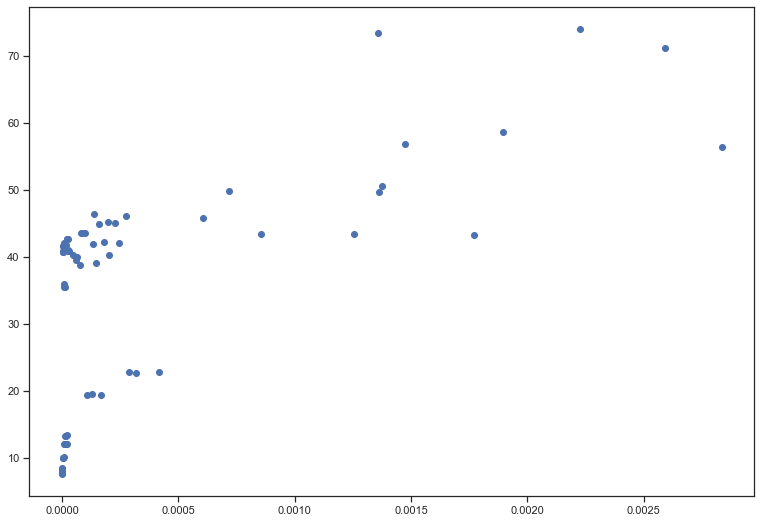

In [377]:
plt.scatter(slopes, weights)

In [11]:
r2_df_new

,"(traces, losses)","(traces, jacobian)","(traces, margins)","(losses, traces)","(losses, jacobian)","(losses, margins)","(jacobian, traces)","(jacobian, losses)","(jacobian, margins)","(margins, traces)",...,batch_train_size,criterion,learning_rate,optimizer,seed,weight_decay,acc_train,acc_test,loss_train,loss_test
1621787441.2034013,0.678685,0.729476,0.971338,NaN,0.891396,0.977430,NaN,NaN,0.993934,NaN,...,256,cross-entropy,0.01,SGD,0,0.0001,0.9522,0.5808,0.130931,2.950856
1621786700.9018226,0.044733,0.217437,0.043659,NaN,0.437734,0.738720,NaN,NaN,0.418955,NaN,...,256,MSE,1,SGD,10,0,0.9216,0.5638,0.015690,0.068652
1621790269.6430342,0.082725,0.028982,0.036462,NaN,0.019699,0.794832,NaN,NaN,0.042675,NaN,...,128,MSE,0.025,SGD,10,0.0001,0.7000,0.5888,0.044973,0.056266
1621787496.530556,0.036044,0.145147,0.072186,NaN,0.074712,0.400288,NaN,NaN,0.217906,NaN,...,256,cross-entropy,0.000025,Adam,0,0.0001,0.4092,0.4036,1.726392,1.753100
1621786647.420346,0.046796,0.093137,0.042303,NaN,0.201037,0.440233,NaN,NaN,0.187814,NaN,...,256,cross-entropy,0.000025,Adam,5,0,0.4500,0.4570,1.584049,1.605596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621786706.9549413,0.060177,0.054584,0.048743,NaN,0.053374,0.783191,NaN,NaN,0.039464,NaN,...,128,MSE,0.05,SGD,10,0,0.7984,0.6034,0.030660,0.057727
1621787550.8746219,0.024064,0.138086,0.047980,NaN,0.114278,0.675255,NaN,NaN,0.067792,NaN,...,256,cross-entropy,0.000005,Adam,0,0.0001,0.3100,0.3096,1.997544,1.996431
1621787382.3898637,0.549985,0.784211,0.908260,NaN,0.696798,0.906974,NaN,NaN,0.992961,NaN,...,256,cross-entropy,0.075,SGD,0,0.0001,0.8656,0.5178,0.437320,2.592184
1621787594.1609957,0.138199,0.014171,0.072132,NaN,0.122407,0.780054,NaN,NaN,0.018148,NaN,...,256,cross-entropy,0.000001,Adam,0,0.0001,0.2070,0.2108,2.255276,2.252788


In [77]:
# ce_models = mf.save_load.get_all_models(experiment_folder, step=-1, device=None)
m = mf.save_load.load_model(os.path.join(experiment_folder, "models", "1621786700.9018226", "step_10001", "model_0.pt"))


TypeError: super(type, obj): obj must be an instance or subtype of type

In [33]:
def compare_nets(m1, m2, N, inp_dim, seed=0):
    x = torch.randn(N, inp_dim)
    y1 = m1(x)
    y2 = m2(x)
    diff = torch.norm(y1 - y2, dim=1)
    return float(torch.mean(diff).detach().numpy())

m1 = ce_models[ce_stats_df.index[0]]["0"]
m2 = ce_models[ce_stats_df.index[1]]["0"]

N = 100
inp_dim = 28*28

# ce_stats_df.index[0]

arr_dists = []
for i in range(81):
    for j in range(i, 81):
        arr_dists.append(compare_nets(ce_models[ce_stats_df.index[i]]["0"], ce_models[ce_stats_df.index[j]]["0"], N, inp_dim, seed=0))

# compare_nets(m1, m2, 1000, 28*28)


# for exp_id in ce_stats_df.index:
#     for exp_id in ce_stats_df.index:

NameError: name 'ce_models' is not defined

In [28]:
import torch

seed = 0
num_datapoints = 100

# m1 = ce_models[ce_stats_df.index[0]]["0"]


train_data, test_data = mf.postprocessing.utils.get_data_for_experiment(experiment_folder)
data = mf.data_getters.get_random_data_subset(train_data, num_datapoints=num_datapoints, seed=seed)

data_loader = DataLoader(data, batch_size=1, shuffle=False)




Files already downloaded and verified
Files already downloaded and verified


In [35]:
m.eval()

res = []

m_new = mf.nets.Nets.DanielNormOutputNet(m)

for i, (inputs, labels) in enumerate(data_loader):

    outputs = m_new(inputs) # get softmax of this 
    temp_res = []
    soft_layer = torch.nn.Softmax(dim=-1)
    for a in np.linspace(1, 10):
        temp_res.append(max(soft_layer(a*outputs).detach().numpy()[0]))
    res.append(temp_res)

In [36]:
int_arr = []
for i in range(len(res)):
    for j in range(i+1, len(res)):
        int_arr.append(do_intersect(res[i], res[j]))
        if int_arr[-1]:
            print("{} {}".format(i, j))
        
# int_arr

0 1
0 10
0 39
0 40
0 42
0 50
0 51
0 52
0 53
0 57
0 66
0 67
0 69
0 79
0 81
0 84
0 88
0 90
0 95
0 99
1 4
1 5
1 10
1 19
1 24
1 27
1 29
1 31
1 32
1 36
1 38
1 39
1 40
1 41
1 42
1 44
1 51
1 56
1 57
1 59
1 65
1 66
1 67
1 69
1 70
1 75
1 79
1 80
1 81
1 84
1 86
1 91
1 94
1 97
1 98
2 48
2 89
3 68
3 72
3 75
3 86
3 87
3 92
4 16
4 19
4 29
4 37
4 38
4 39
4 56
4 61
4 68
4 70
4 72
4 78
4 87
4 90
4 95
4 97
4 98
5 10
5 24
5 29
5 32
5 39
5 40
5 41
5 42
5 50
5 51
5 52
5 57
5 59
5 78
5 79
5 88
5 90
5 95
6 73
7 9
7 43
7 49
7 52
7 65
7 74
7 77
7 93
7 95
7 99
8 72
8 86
8 87
8 92
9 43
9 49
9 50
9 52
9 58
9 65
9 77
9 93
9 95
9 99
10 24
10 27
10 29
10 32
10 37
10 38
10 39
10 40
10 41
10 42
10 50
10 51
10 52
10 53
10 56
10 57
10 59
10 66
10 67
10 78
10 79
10 80
10 81
10 87
10 88
10 90
10 95
10 99
11 26
11 33
11 49
11 54
11 63
12 15
12 43
12 49
12 58
12 65
12 77
12 93
13 25
13 28
13 33
13 49
13 54
13 58
13 62
13 71
13 82
13 93
14 22
14 26
14 33
14 45
14 46
14 47
14 49
14 54
14 64
14 76
14 93
15 25
15 43
15 49
15 52

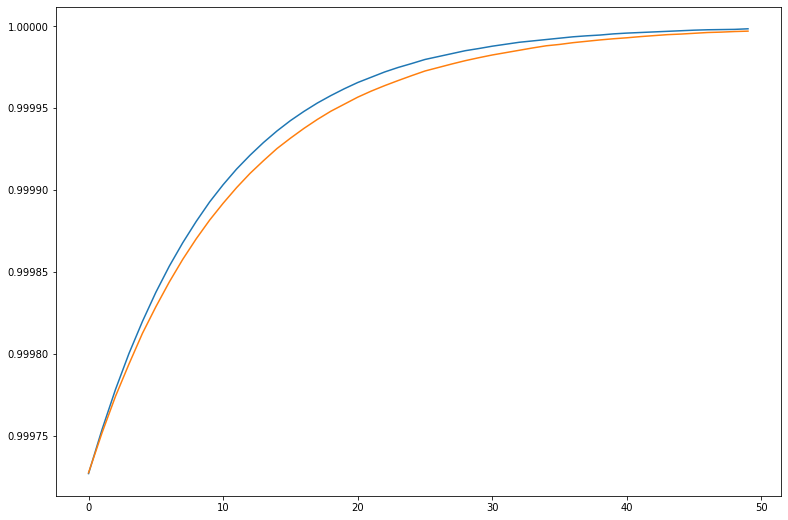

In [168]:
plt.plot(res[48])
plt.plot(res[71])
# plt.xlim(40, 50)

In [413]:
arr_dists = np.array([np.array(dict_dists[i]) for i in range(81)])

In [34]:
def do_intersect(res1, res2):
    for i in range(len(res1)):
        if res1[0] < res2[0]:
            if res1[i] > res2[i]:
                return True
        if res1[0] > res2[0]:
            if res1[i] < res2[i]:
                return True
    return False

In [111]:
import numpy as np

delta = 2
for _ in range(100):
    a = np.random.random(10)
    a[0] = delta*max(a)


    res1 = []
    for i in np.linspace(0, 100):
        o = np.exp(i*a) / np.sum(np.exp(i*a))
        res1.append(o.dot(o))

    res1 = np.array(res1)


    a = np.random.random(10)
    a[0] = delta*max(a)

    res2 = []
    for i in np.linspace(0, 100):
        o = np.exp(i*a) / np.sum(np.exp(i*a))
        res2.append(o.dot(o))

    res2 = np.array(res2)
    print(do_intersect(res1, res2))

False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
True
True
True
False
True
False
False
False
True
False
False
False
False
True
False
True
True
False
False
False
False
True
False
True
False
True
False
False
True
False
False
False
True
False
False
False
True
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
True
False
False
False


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import os, pickle


from random import random

In [6]:
train_data = torchvision.datasets.KMNIST("/Users/daniellengyel/deep_generalizability/experiments/KMNIST", train=True,
                                            download=True,
                                            transform=torchvision.transforms.Compose([
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(
                                                    (0.1307,), (0.3081,))
                                            ]))


Extracting /Users/daniellengyel/deep_generalizability/experiments/KMNIST/KMNIST/raw/train-images-idx3-ubyte.gz to /Users/daniellengyel/deep_generalizability/experiments/KMNIST/KMNIST/raw


Extracting /Users/daniellengyel/deep_generalizability/experiments/KMNIST/KMNIST/raw/train-labels-idx1-ubyte.gz to /Users/daniellengyel/deep_generalizability/experiments/KMNIST/KMNIST/raw



Extracting /Users/daniellengyel/deep_generalizability/experiments/KMNIST/KMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/daniellengyel/deep_generalizability/experiments/KMNIST/KMNIST/raw


Extracting /Users/daniellengyel/deep_generalizability/experiments/KMNIST/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/daniellengyel/deep_generalizability/experiments/KMNIST/KMNIST/raw
Processing...
Done!


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
train_data.shape

AttributeError: 'KMNIST' object has no attribute 'shape'

In [27]:
d = np.array(iter(DataLoader(train_data, batch_size=1, shuffle=True)).next()[0].detach().numpy())

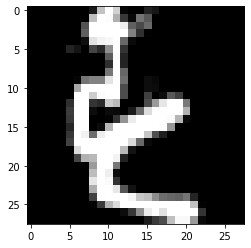

In [28]:
plt.imshow(d.reshape(28,28), cmap="gray")


In [13]:
import matplotlib.pyplot as plt

In [ ]:
id_type = "best"

if id_type == "worst":
    exp_id, exp_kendall = min(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
elif id_type == "best":
    exp_id, exp_kendall = max(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
else:
    exp_id, exp_kendall = sorted(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))[len(ce_kendall_coeffs)//2]

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_all_point_output_margins[exp_id]["0"]
y_data = ce_all_point_traces[exp_id]["0"]
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
ax1.set_ylim(-250, 3500)


ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

axins2 = inset_axes(ax1, width=4, height=4, loc=1)
sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# sub region of the original image
x1, x2, y1, y2 = 10, 16, -0.6, 1
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [61]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "CIFAR10"

exp_name = "LeNet_short"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp_name)

exp_ids = ["1621787441.2034013"]

meta = {"criterion": "cross-entropy", "normalize_output": True}
traces_CE = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "point_traces", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)

# meta = {"criterion": "MSE"}
# traces_MSE = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "point_traces", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)

# meta = {"criterion": "normalized-cross-entropy"}
# traces_norm_CE = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "point_traces", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)




Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]


TypeError: super(type, obj): obj must be an instance or subtype of type

In [19]:
meta = None # {"criterion": "cross-entropy"}
jacob = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "inp_out_jacobian", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)




Files already downloaded and verified
Files already downloaded and verified


432it [00:00, 2331.44it/s]


In [20]:
margins = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "output_margins", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=None)


Files already downloaded and verified
Files already downloaded and verified


432it [00:00, 9753.99it/s]


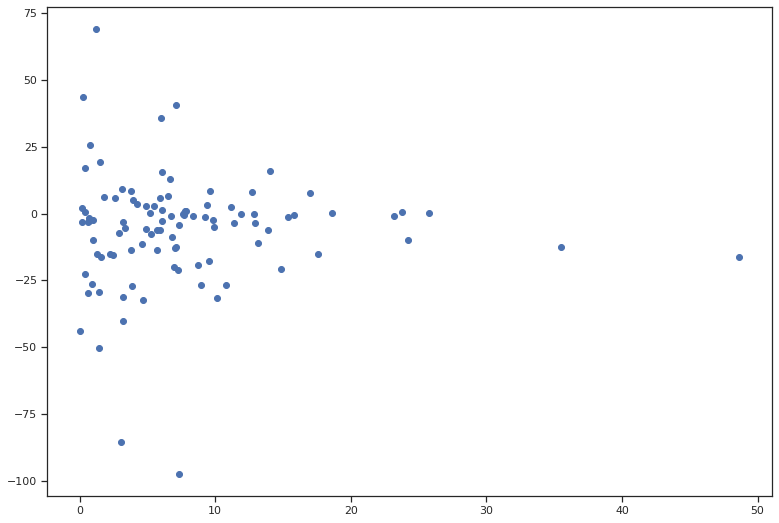

In [23]:
exp_id = exp_ids[0]
x_data = margins[exp_id]['0']
y_data = traces_norm_CE[exp_id]['0']
plt.scatter(x_data, y_data)
# plt.xlim(-10, 20)
# plt.ylim(-0.1,0.1)

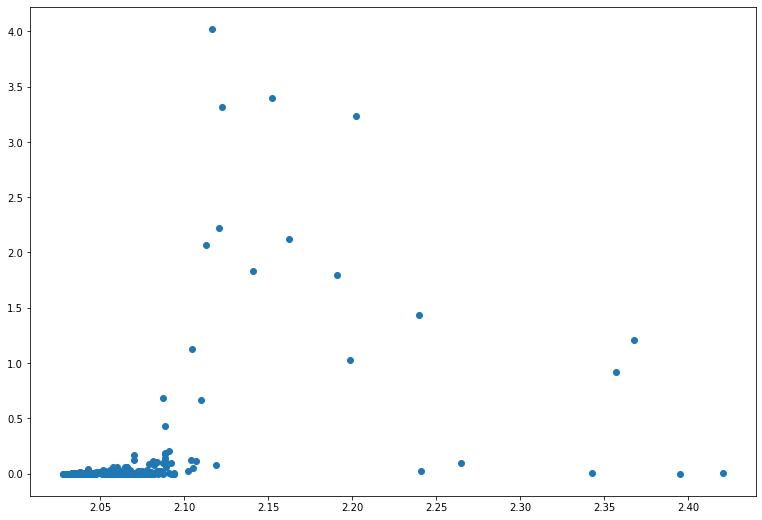

In [52]:
post_dict
exp_id = "1621270447.8047616"
x_data = post_dict["losses"][exp_id]['0']
y_data = post_dict["jacobian"][exp_id]['0']
plt.scatter(x_data, y_data)
# plt.xlim(-10, 20)
# plt.ylim(-0.1,0.1)

In [14]:
mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=False)#, increasing="auto")

KendalltauResult(correlation=0.1928947383866885, pvalue=0.00648198907843077)

In [59]:
loss, acc = mf_post.postprocess_experiment.get_exp_loss_acc(experiment_folder, -1, seed=0, num_train_datapoints=1000, num_test_datapoints=200, device=None, check_cache = True)

Got cached results.


In [61]:
loss_df = pd.DataFrame(data=[loss[k]['0'] for k in loss], index=list(loss.keys()), columns=["train_loss", "test_loss"])
acc_df = pd.DataFrame(data=[acc[k]['0'] for k in acc], index=list(acc.keys()), columns=["train_acc", "test_acc"])

In [ ]:
May19_00-32-38_cx3-7-9.cx3.hpc.ic.ac.uk

In [33]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "KMNIST"

exp_name = ""

exp_name = "w128_l8_ReLU" # "May19_00-32-38_cx3-7-9.cx3.hpc.ic.ac.uk" # "May19_02-49-40_cx3-3-0.cx3.hpc.ic.ac.uk"#
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp_name)
